<a href="https://colab.research.google.com/github/Snigdho64/Google_Collab_Notebooks/blob/main/Food_101_full_dataset_mixed_precision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the Environment Ready

Using [**mixes precision training**](https://www.tensorflow.org/guide/mixed_precision)


In [ ]:
# If using Google Colab, this should output "Tesla T4" otherwise, 
# you won't be able to use mixed precision training
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ade0c882-4e44-d37b-d4e1-09c9d2fb38c6)


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras

In [ ]:
tf.__version__,keras.__version__

('2.7.0', '2.7.0')

###Dataset : `food101`
1. train sample size : ,7,500 * 101
2. test sample size : 2,500 *101

In [ ]:
#List of all the available datasets
datasets_list = tfds.list_builders()
datasets_list

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

In [ ]:
#Check for our required dataset
'food101' in datasets_list

True

#1. Loading and Extracting the Data from `tensorflow_datasets`

In [ ]:
#Load the datasets (takes about 5 - 6 minutes)
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteCINNHL/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteCINNHL/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

# 2. Exploratory Data Analysis
Inspect the data
Visualise the data

In [ ]:
!pip install wget
import transfer_learning_helper as helper

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=4aaaae95ec50cc61177287b697f5dcdff31494aabef0796d3355aa7d889a6690
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
#HELPER FUNCTION 1
def show_tf_batched_image(tf_dataset,num_images=1,class_names=class_names,figsize=(8,6)):
  '''
  Displays a random image genrated from `keras.preprocessing.image_dataset_from_directory`
  Args:
  batched_data : image data generated using `image_dataset_from_directory`
  '''
  import random

  n = int(np.sqrt(num_images))+1 if num_images>1 else 1 
  
  fig,axes = plt.subplots(nrows=n,ncols=n+1,figsize=(n*8,(n+1)*6))
  axes = axes.flatten() if num_images>1 else [axes]

  for ax,img,label in zip(axes,*zip(*tf_dataset.take(num_images))):
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_title(f'Label :{class_names[label]}',fontsize=18)
      ax.set_xlabel(f'Image Shape :{img.shape}',fontsize=16)
      ax.imshow(img*1/225);

  for i in range(n*(n+1) - num_images):
    idx = i*(-1) - 1
    fig.delaxes(axes[idx]);

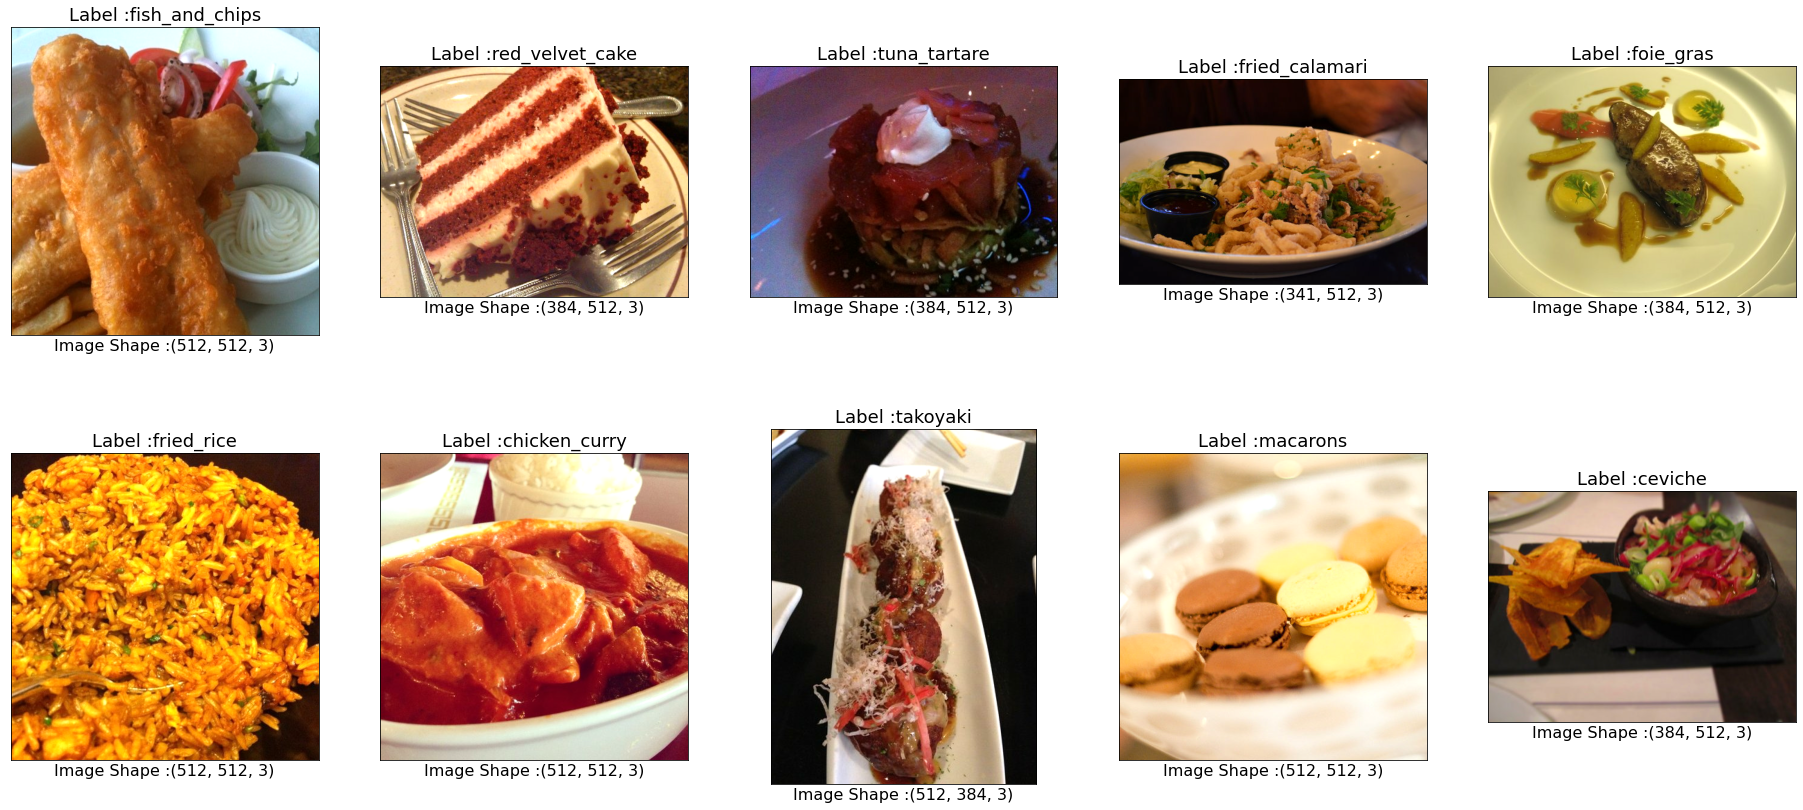

In [ ]:
show_tf_batched_image(train_data,num_images=);

In [ ]:
sample = train_data.list_files

In [ ]:
list(zip([1,2,3],*zip(*train_data.take(3))))[0]

(1, <tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
 array([[[189, 165, 121],
         [185, 161, 117],
         [181, 157, 113],
         ...,
         [111,  72,  33],
         [103,  64,  25],
         [ 94,  55,  16]],
 
        [[186, 162, 118],
         [183, 159, 115],
         [180, 156, 112],
         ...,
         [122,  83,  40],
         [113,  74,  31],
         [105,  66,  23]],
 
        [[180, 156, 112],
         [178, 154, 110],
         [177, 153, 109],
         ...,
         [132,  94,  45],
         [124,  87,  35],
         [120,  83,  31]],
 
        ...,
 
        [[207, 204, 159],
         [205, 201, 154],
         [204, 196, 147],
         ...,
         [231, 225, 191],
         [231, 225, 189],
         [231, 226, 188]],
 
        [[207, 204, 159],
         [205, 201, 154],
         [204, 196, 147],
         ...,
         [230, 224, 190],
         [230, 224, 188],
         [229, 223, 187]],
 
        [[206, 203, 158],
         [204, 200, 153],
         [2